In [1]:
###################################################
import emcee
import numpy as np
import scipy
from astropy.io import fits
from astropy.table import Table
from astropy.io import fits
import matplotlib.pyplot as plt
from astropy.table import Table
from astropy.coordinates import SkyCoord
import astropy.units as u
from astropy.cosmology import Planck18 as cosmo
from functools import partial
import time
from astropy.coordinates import SkyCoord
import astropy.units as u
import pyccl as ccl
import clevar
import numpy as np
from astropy.table import Table
import clmm
from clevar.catalog import ClCatalog, MemCatalog
from clevar.match_metrics import recovery
import matplotlib.pyplot as plt
from clevar.match import MembershipMatch
from clevar.match_metrics import distances
from clevar.match_metrics import scaling
from clevar.match import ProximityMatch
from clevar.match_metrics.recovery import ClCatalogFuncs as r_cf
###################################################

# Imports Catalog and creats a table (t_cl_match) containing Mass ('M'), redshift ('zp') and richness ('n200')


path_halo = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags_FULL/zband/member_matching/fshare1_0.1_fshare2_0.1_pref_more_massive_mbmt_id/cat1.fits'

path_cl = '/sps/lsst/groups/clusters/cluster_comparison_project/after_matching/cosmoDC2_pywazp.DC2.tpz.T500k.pointEstimateMags_FULL/zband/member_matching/fshare1_0.1_fshare2_0.1_pref_more_massive_mbmt_id/cat2.fits'

t = Table.read(path_cl)

def table(path):
    with fits.open(path) as hdul:
        table = Table(hdul[1].data)
    return table

t_halo = Table.read(path_halo)
t_cl = Table.read(path_cl)
t_cl_match = t_cl[~t_cl["mt_cross"].mask]
display(t_halo, t_cl)
M = []
z_h = []
ra_true = []
dec_true = []

for idx in t_cl_match["mt_cross"]:
    ligne = t_halo[t_halo["halo_id"] == idx]

    if len(ligne) != 1:
        raise ValueError(
            f"halo_id {idx} matched {len(ligne)} rows"
        )

    M.append(ligne["m200c"][0])
    z_h.append(ligne["redshift_true"][0])
    ra_true.append(ligne["ra_true"][0])
    dec_true.append(ligne["dec_true"][0])
t_cl_match["m200c"] = M
t_cl_match["z_h"] = z_h
t_cl_match["ra_true"] = ra_true
t_cl_match["dec_true"] = dec_true

t_cl_match = t_cl_match[t_cl_match["snr"]>6]
t_cl_match = t_cl_match[t_cl_match["n200"]>20]


Mp, zp = 10**14.3, 0.5

###################################################
coord_cl = SkyCoord(t_cl_match['ra'], t_cl_match['dec'], unit='deg')
coord_h  = SkyCoord(t_cl_match['ra_true'], t_cl_match['dec_true'], unit='deg')

sep = coord_cl.separation(coord_h)
print("Median sep:", np.median(sep.to(u.arcmin)))
print("Max sep:", np.max(sep.to(u.arcmin)))

cosmo_dc2 = ccl.Cosmology(
    Omega_c=0.2616,      # Omega_m - Omega_b = 0.3106 - 0.049
    Omega_b=0.049,
    h=0.675,
    sigma8=0.8,
    n_s=0.965,
    m_nu=0.0,            # CosmoDC2 used massless neutrinos
    w0=-1.0, 
    wa=0.0
)


halo_id,ra_obs,dec_obs,ra_true,dec_true,redshift_true,m200c,NMEM,NMEM_z_star1.5,radius,cf_nfw_1_mpc,mt_self,mt_other,mt_multi_self,mt_multi_other,mt_cross
bytes21,float64,float64,float64,float64,float64,float64,int64,int64,float64,float64,bytes6,bytes6,bytes33,bytes33,bytes6
52300151442,51.070122482361214,-39.64548257286864,51.06907727982047,-39.64607328475867,0.1259174346923828,58720563188461.98,58,11,0.7652401958156531,0.936747450247421,15453,15453,15453,15453,15453
70700151421,50.52654279437244,-39.75897863844969,50.52541974335929,-39.759854374325954,0.16475677490234375,68254428849397.19,39,15,0.7924458173540291,0.9216195665636749,9059,9059,9059,9059,9059
78600151411,50.54206587178339,-39.07029660265149,50.54038986767568,-39.0704158967892,0.21005773544311523,120390041092326.77,93,19,0.9402486232101316,0.7994640896805603,--,--,--,--,--
130200151411,50.642098246561304,-41.40092456771352,50.64208660915858,-41.40265859512897,0.19159162044525146,229655937300912.7,202,68,1.174819933186866,0.9659986371753817,256,256,256,"256,134524",256
191900151411,51.1967242492188,-40.87789708933638,51.19489753953479,-40.87828426780436,0.18677890300750732,116379211308709.86,54,18,0.9384444396096316,0.9650223233074378,72568,72568,"72568,61280","72568,61280",72568
253900151411,50.130998120959816,-41.24745697262069,50.13040773558871,-41.24880382828121,0.19323325157165527,58288508524169.016,36,13,0.7433387491396962,0.7568200840257265,--,--,--,--,--
95200151401,51.521245348058855,-40.75126448740972,51.51918683257815,-40.75236849405238,0.23941683769226074,52557263851808.45,49,14,0.7047959886908872,0.937957752039141,25836,25836,"52,25836",25836,25836
138000151401,50.34886527558379,-40.835004119693025,50.34738589649655,-40.83606966007568,0.23906373977661133,96358882658794.38,66,20,0.8627386436891459,0.9789540706377415,8015,8015,"8015,77018","8015,77018",8015
253700151401,50.47437292850503,-41.13949239868323,50.47349722884375,-41.140801495255715,0.22013604640960693,40392024779357.75,37,11,0.650681936233804,0.9427390844099328,51682,51682,51682,51682,51682


id,ra,dec,zp,n200,n200_err,snr,raw_coverfrac,weighted_coverfrac,bkg_coverfrac,mt_self,mt_other,mt_multi_self,mt_multi_other,mt_cross
bytes30,float64,float64,float32,float32,float32,float32,float32,float32,float32,bytes13,bytes13,bytes40,bytes82,bytes13
193028,49.573452898865064,-44.19856875299083,0.91671336,6.376,0.523,3.002,69.4,75.7,48.6,--,--,--,--,--
98081,49.6256607949887,-44.13217144566751,0.48552513,13.859,2.681,4.106,85.8,93.1,52.8,--,117600185323,--,117600185323,--
79976,49.62747410750222,-44.24822082065141,0.6869996,14.41,2.593,4.422,93.8,97.3,52.0,--,--,--,--,--
125281,49.63162372606795,-44.29258668292809,0.6310984,5.504,0.963,3.718,94.8,96.6,49.8,--,--,--,--,--
28076,49.63867447643211,-44.13613370188215,0.2789399,11.002,1.894,6.104,80.4,90.1,47.2,--,--,--,--,--
176286,49.64861908610109,-44.10978821648175,0.8442942,5.215,1.338,3.16,95.3,96.3,57.7,--,--,--,--,--
76639,49.652316087449314,-43.99831698753705,0.4461611,7.253,2.427,4.487,80.3,89.8,52.6,--,--,--,--,--
162375,49.663685012012536,-44.05312738361619,0.8984465,9.242,0.889,3.298,90.9,90.1,56.5,--,--,--,--,--
153302,49.672625936512404,-44.400156914868234,1.2347945,8.557,0.52,3.392,93.8,90.4,54.2,--,--,--,--,--


Median sep: 0.515802 arcmin
Max sep: 8.43201 arcmin


## Mass-Richness

In [2]:
def prior(params):
    if len(params) == 6:
        A, B, C, D, E, F = params
        if -2<C<2 and -2<E<2 and -2<F<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False
    else:
        A, B, D, E = params
        if -2<E<2 and A > 0 and B > 0 and D > 0:
            return True
        else:
            return False

In [3]:
def _ln_L(params, X, a, b, use_correction):
    # 1. Prior Check
    if not prior(params):
        return -np.inf
    
    # 2. Extract Data & Params
    pop, M, z = np.log(X["n200"]), X["m200c"], X["zp"]
    
    if len(params) == 6:
        A, B, C, D, E, F = params
        mean_alpha = A + B*np.log(M/Mp) + C*np.log((1+z)/(1+zp))
        sigma = D + E*np.log(M/Mp) + F*np.log((1+z)/(1+zp))
    else:
        A, B, D, E = params
        mean_alpha = A + B*np.log(M/Mp)
        sigma = D + E*np.log(M/Mp)
    
    # 3. Physicality Check (Sigma must be positive for all points)
    if np.any(sigma <= 0):
        return -np.inf
    
    # 4. Standard Log-likelihood calculation
    # Using np.sum for speed and stability
    term1 = -0.5 * np.log(2 * np.pi * sigma**2)
    term2 = -0.5 * ((pop - mean_alpha) / sigma)**2
    ln_L = np.sum(term1 + term2)
    
    # 5. Optional Truncation Correction (Corrected logic)
    if use_correction:
        # P(a < n200 < b) = 0.5 * [erf((log(b)-mu)/(sig*sqrt2)) - erf((log(a)-mu)/(sig*sqrt2))]
        inv_sig_root2 = 1.0 / (sigma * np.sqrt(2))
        def erf_func(val):
            return scipy.special.erf((np.log(val) - mean_alpha) * inv_sig_root2)
        
        prob_in_bin = 0.5 * (erf_func(b) - erf_func(a))
        # Add the log of the normalization to the total likelihood
        ln_L -= np.sum(np.log(np.clip(prob_in_bin, 1e-10, None)))
        
    return ln_L

def MCMC(richesse_bin, redshift_bin, itt, redshift_params=True, correction=True):
    a, b = richesse_bin
    c, d = redshift_bin
    
    # Selection
    mask = (t_cl_match["n200"] > a) & (t_cl_match["n200"] < b) & \
           (t_cl_match["zp"] > c) & (t_cl_match["zp"] < d)
    X = t_cl_match[mask]
    
    if len(X) < 10: # Safety check for empty bins
        print(f"Warning: Bin {richesse_bin}, {redshift_bin} has only {len(X)} clusters.")
        return {'mean': np.zeros(6 if redshift_params else 4), 'std': np.zeros(6 if redshift_params else 4)}

    ndim = 6 if redshift_params else 4
    nwalkers = 24 # Use a multiple of 2 or 4 for better threading
    
    # Better initialization
    if redshift_params:
        guess = np.array([3.2, 0.8, 0.1, 0.5, 0.01, 0.01])
    else:
        guess = np.array([3.2, 0.8, 0.5, 0.01])
        
    p0 = [guess + 1e-4 * np.random.randn(ndim) for i in range(nwalkers)]
    
    sampler = emcee.EnsembleSampler(nwalkers, ndim, _ln_L, args=[X, a, b, correction])
    sampler.run_mcmc(p0, itt, progress=True)
    
    # Correct result extraction (Flattening)
    burn_in = int(itt * 0.3)
    unflat_samples = sampler.get_chain(discard=burn_in, flat=False)
    flat_samples = sampler.get_chain(discard=burn_in, flat=True)    
    return {
        'chains': unflat_samples,
        'mean': np.mean(flat_samples, axis=0),
        'std': np.std(flat_samples, axis=0)
    }

In [4]:

# from tqdm import tqdm


# ##################################################################################
# mat_mean_A = np.zeros((3, 3))
# mat_std_A = np.zeros((3, 3))

# mat_mean_B = np.zeros((3, 3))
# mat_std_B = np.zeros((3, 3))

# mat_mean_C = np.zeros((3, 3))
# mat_std_C = np.zeros((3, 3))

# mat_mean_D = np.zeros((3, 3))
# mat_std_D = np.zeros((3, 3))

# mat_mean_E = np.zeros((3, 3))
# mat_std_E = np.zeros((3, 3))

# mat_mean_F = np.zeros((3, 3))
# mat_std_F = np.zeros((3, 3))


# list_bin_richesse = [(20, 35), (35, 70), (70, 100)]
# list_bin_redshift = [(0.2, 0.5), (0.5, 0.8), (0.8, 1.5)]


# # Paramétrisation par MCMC
# #####################################################################################################
# total_bins = len(list_bin_redshift) * len(list_bin_richesse)

# with tqdm(total=total_bins, desc="Overall Progress") as pbar:
#     for bin_z in range(3):
#         for bin_n200 in range(3):
#             res = MCMC(richesse_bin=list_bin_richesse[bin_n200], 
#                        redshift_bin=list_bin_redshift[bin_z], 
#                        itt=3000, redshift_params=True, correction=False)
            
#             m = res['mean']
#             s = res['std']
            
#             # Store results (handling 6 parameters)
#             mat_mean_A[bin_z, bin_n200], mat_mean_B[bin_z, bin_n200], mat_mean_C[bin_z, bin_n200], \
#             mat_mean_D[bin_z, bin_n200], mat_mean_E[bin_z, bin_n200], mat_mean_F[bin_z, bin_n200] = m
            
#             mat_std_A[bin_z, bin_n200], mat_std_B[bin_z, bin_n200], mat_std_C[bin_z, bin_n200], \
#             mat_std_D[bin_z, bin_n200], mat_std_E[bin_z, bin_n200], mat_std_F[bin_z, bin_n200] = s
#             pbar.update(1)

# # Affichage
# #######################################################################################################
# bin_centers = np.array([27.5, 52.5, 85.0])
# bin_labels = ['20-35', '35-70', '70-100']
# fig, ax = plt.subplots(2, 3, figsize=(18, 8), sharex=False, sharey=False)
# x = bin_centers

# ax[0, 0].errorbar(x, mat_mean_A[0], yerr = mat_std_A[0], label = "0.2 < z < 0.5")
# ax[0, 0].errorbar(x, mat_mean_A[1], yerr = mat_std_A[1], label = "0.5 < z < 0.8")
# ax[0, 0].errorbar(x, mat_mean_A[2], yerr = mat_std_A[2], label = "0.8 < z < 1.5")
# ax[0, 0].set_title('A')
# ax[0, 0].set_xlabel('Bin de Richesse')
# ax[0, 0].legend()
# ax[0, 0].grid()
# # Appliquer les labels personnalisés
# ax[0, 0].set_xticks(bin_centers)
# ax[0, 0].set_xticklabels(bin_labels)

# ax[0, 1].errorbar(x, mat_mean_B[0], yerr = mat_std_B[0], label = "0.2 < z < 0.5")
# ax[0, 1].errorbar(x, mat_mean_B[1], yerr = mat_std_B[1], label = "0.5 < z < 0.8")
# ax[0, 1].errorbar(x, mat_mean_B[2], yerr = mat_std_B[2], label = "0.8 < z < 1.5")
# ax[0, 1].set_title('B')
# ax[0, 1].set_xlabel('Bin de Richesse')
# ax[0, 1].legend()
# ax[0, 1].grid()
# # Appliquer les labels personnalisés
# ax[0, 1].set_xticks(bin_centers)
# ax[0, 1].set_xticklabels(bin_labels)

# ax[1, 0].errorbar(x, mat_mean_D[0], yerr = mat_std_D[0], label = "0.2 < z < 0.5")
# ax[1, 0].errorbar(x, mat_mean_D[1], yerr = mat_std_D[1], label = "0.5 < z < 0.8")
# ax[1, 0].errorbar(x, mat_mean_D[2], yerr = mat_std_D[2], label = "0.8 < z < 1.5")
# ax[1, 0].set_title('D')
# ax[1, 0].set_xlabel('Bin de Richesse')
# ax[1, 0].legend()
# ax[1, 0].grid()
# # Appliquer les labels personnalisés
# ax[1, 0].set_xticks(bin_centers)
# ax[1, 0].set_xticklabels(bin_labels)

# ax[1, 1].errorbar(x, mat_mean_E[0], yerr = mat_std_E[0], label = "0.2 < z < 0.5")
# ax[1, 1].errorbar(x, mat_mean_E[1], yerr = mat_std_E[1], label = "0.5 < z < 0.8")
# ax[1, 1].errorbar(x, mat_mean_E[2], yerr = mat_std_E[2], label = "0.8 < z < 1.5")
# ax[1, 1].set_title('E')
# ax[1, 1].set_xlabel('Bin de Richesse')
# ax[1, 1].legend()
# ax[1, 1].grid()
# # Appliquer les labels personnalisés
# ax[1, 1].set_xticks(bin_centers)
# ax[1, 1].set_xticklabels(bin_labels)


# bin_centers_z = np.array([0.35, 0.65, 1.15])
# bin_labels_z = ['0.2-0.5', '0.5-0.8', '0.8-1.5']
# x_z = bin_centers_z

# ax[0, 2].errorbar(x_z, mat_mean_C[:,0], yerr = mat_std_C[:,0], label = r"20 < $\lambda$ < 35")
# ax[0, 2].errorbar(x_z, mat_mean_C[:,1], yerr = mat_std_C[:,1], label = r"35 < $\lambda$ < 70")
# ax[0, 2].errorbar(x_z, mat_mean_C[:,2], yerr = mat_std_C[:,2], label = r"70 < $\lambda$ < 100")
# ax[0, 2].set_title('C')
# ax[0, 2].set_xlabel('Bin de Redshift')
# ax[0, 2].legend()
# ax[0, 2].grid()
# # Appliquer les labels personnalisés
# ax[0, 2].set_xticks(bin_centers_z)
# ax[0, 2].set_xticklabels(bin_labels_z)

# ax[1, 2].errorbar(x_z, mat_mean_F[:,0], yerr = mat_std_F[:,0], label = r"20 < $\lambda$ < 35")
# ax[1, 2].errorbar(x_z, mat_mean_F[:,1], yerr = mat_std_F[:,1], label = r"35 < $\lambda$ < 70")
# ax[1, 2].errorbar(x_z, mat_mean_F[:,2], yerr = mat_std_F[:,2], label = r"70 < $\lambda$ < 100")
# ax[1, 2].set_title('F')
# ax[1, 2].set_xlabel('Bin de Redshift')
# ax[1, 2].legend()
# ax[1, 2].grid()
# # Appliquer les labels personnalisés
# ax[1, 2].set_xticks(bin_centers_z)
# ax[1, 2].set_xticklabels(bin_labels_z)






# plt.tight_layout()
# plt.show()


### Unbinned

100%|██████████| 5000/5000 [00:29<00:00, 169.62it/s]


A: mean=3.6536, std=0.0101
B: mean=0.2848, std=0.0100
C: mean=0.0456, std=0.0555
D: mean=0.3594, std=0.0066
E: mean=0.0816, std=0.0056
F: mean=-0.0467, std=0.0375


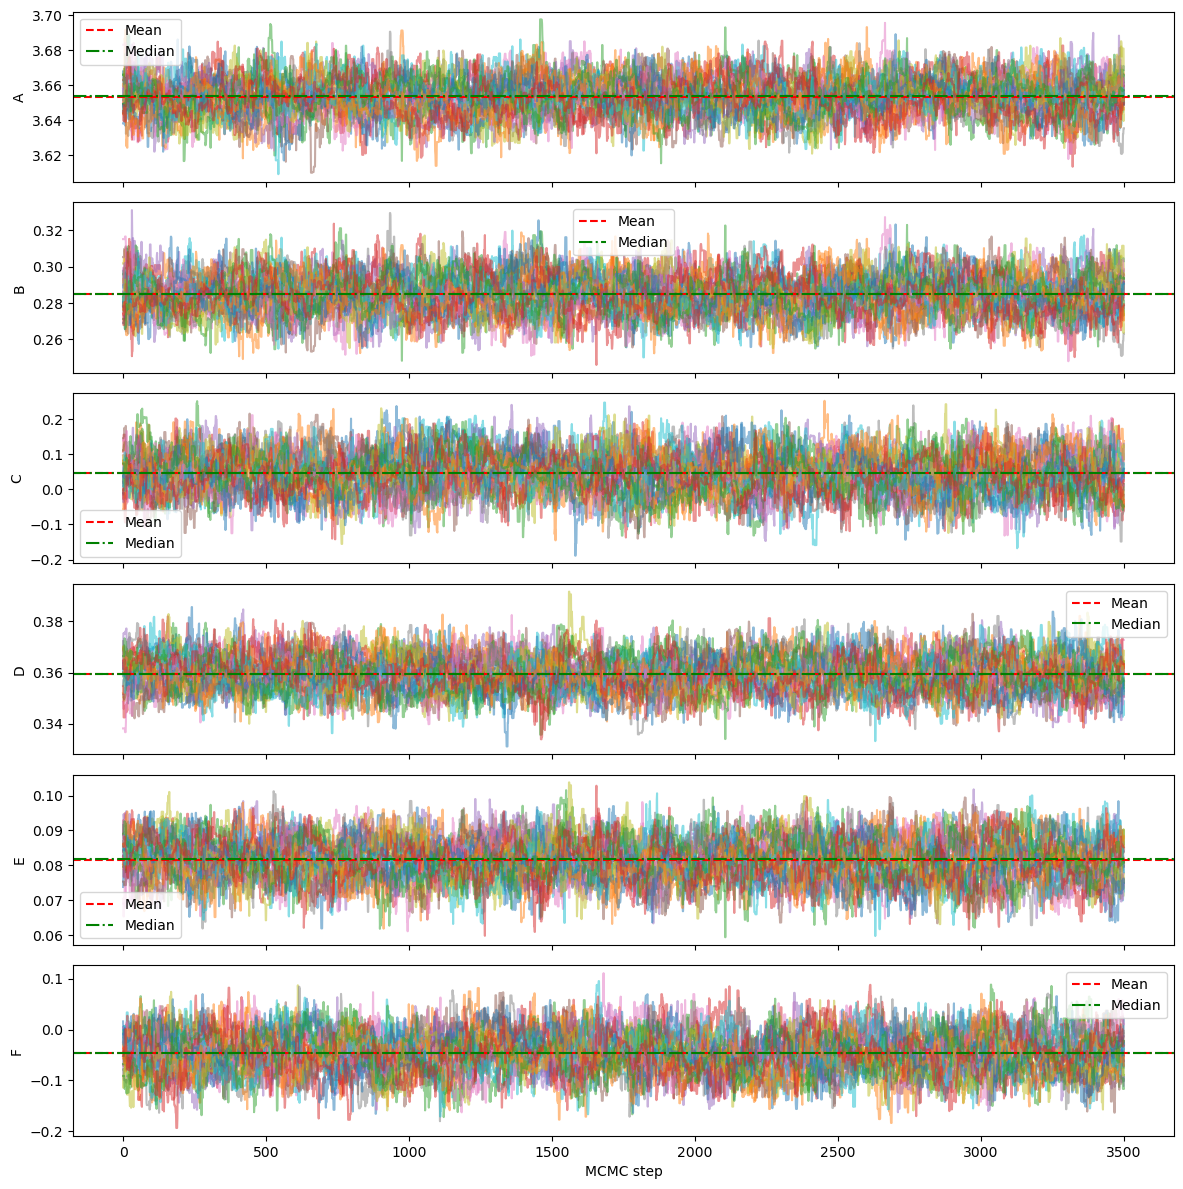

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm

# ------------------------------------------------------------------------------
# Assuming you run MCMC once for all clusters (global), returns 6 parameters
# ------------------------------------------------------------------------------

# Run your MCMC once
res = MCMC(richesse_bin=(20,100), 
           redshift_bin=(0.2,0.8), 
           itt=5000, redshift_params=True, correction=False)

# Extract chains and statistics
chains = res['chains']  # shape: (nsteps, nwalkers, 6) or similar
means = res['mean']     # length 6
stds  = res['std']      # length 6

# Print best-fit values
param_names = ['A','B','C','D','E','F']
for i, name in enumerate(param_names):
    print(f"{name}: mean={means[i]:.4f}, std={stds[i]:.4f}")

# ------------------------------------------------------------------------------
# Plot chains to check convergence
# ------------------------------------------------------------------------------
n_params = 6
nsteps, nwalkers = chains.shape[0], chains.shape[1]

fig, axes = plt.subplots(n_params, 1, figsize=(12, 2*n_params), sharex=True)
for i in range(n_params):
    ax = axes[i]
    for w in range(nwalkers):
        ax.plot(chains[:, w, i], alpha=0.5)
    # Show mean and median lines
    mean_i = np.mean(chains[:, :, i])
    median_i = np.median(chains[:, :, i])
    ax.axhline(mean_i, color='red', linestyle='--', label='Mean')
    ax.axhline(median_i, color='green', linestyle='-.', label='Median')
    ax.set_ylabel(param_names[i])
    ax.legend()
axes[-1].set_xlabel('MCMC step')
plt.tight_layout()
plt.show()


In [6]:
## Miscentering

Angular separation: min=2.0819579188342427e-05, max=0.14053353414197883
Max R_off [Mpc]: 2.2943
Mean R_off [Mpc]: 0.2654
Median R_off [Mpc]: 0.2237


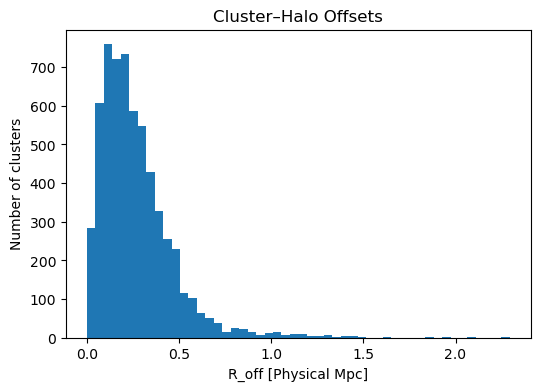

In [7]:
table_cl = Table([t_cl_match['id'], t_cl_match['ra'], t_cl_match['dec'], t_cl_match['zp']],
                 names=['id','ra','dec','redshift'])
table_halo = Table([t_cl_match['id'], t_cl_match['ra_true'], t_cl_match['dec_true'], t_cl_match['z_h']],
                   names=['id','ra','dec','redshift'])

cat_cl = ClCatalog('clusters', data=table_cl)
cat_halo = ClCatalog('halos', data=table_halo)

mt = ProximityMatch()
ang_sep = mt._get_dist_mt(cat_cl, cat_halo, "angular_proximity")  # could be in deg or arcmin

print(f"Angular separation: min={np.min(ang_sep)}, max={np.max(ang_sep)}")

ang_sep_rad = np.deg2rad(ang_sep)


cosmo = clevar.cosmology.AstroPyCosmology()
R_off = cosmo.rad2mpc(ang_sep_rad, cat_halo['redshift'])

# Step 5 — Add to your table
t_cl_match['R_off'] = R_off

# Step 6 — Diagnostics
print(f"Max R_off [Mpc]: {np.max(R_off):.4f}")
print(f"Mean R_off [Mpc]: {np.mean(R_off):.4f}")
print(f"Median R_off [Mpc]: {np.median(R_off):.4f}")

# Step 7 — Histogram
plt.figure(figsize=(6,4))
plt.hist(R_off, bins=50)
plt.xlabel("R_off [Physical Mpc]")
plt.ylabel("Number of clusters")
plt.title("Cluster–Halo Offsets")
plt.show()

MCMC progress: 100%|██████████| 50000/50000 [00:31<00:00, 1589.00it/s]

Sigma offset: 0.133 +0.001 -0.001 Mpc


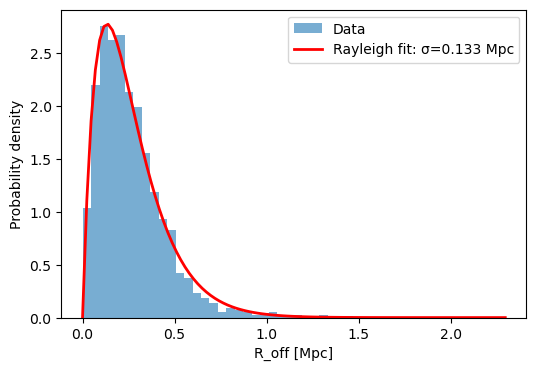

The paper offset is: 0.001449


In [8]:
R = np.array(t_cl_match['R_off'])  # in Mpc
def log_likelihood(theta, R):
    sigma = theta[0]
    if sigma <= 0:
        return -np.inf
    return np.sum(np.log(R / sigma**2) - R / sigma)

def log_prior(theta):
    sigma = theta[0]
    if 0 < sigma < 5.0:  # Mpc
        return 0.0
    return -np.inf

def log_posterior(theta, R):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta, R)

# MCMC setup
ndim = 1  # only sigma
nwalkers = 32
nsteps = 50000
np.random.seed(42)
initial = 0.2 + 0.01 * np.random.randn(nwalkers, ndim)

sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior, args=(R,))

samples_list = []
with tqdm(total=nsteps, desc="MCMC progress") as pbar:
    for sample in sampler.sample(initial, iterations=nsteps, progress=False):
        pbar.update(1)
    samples_list.append(sampler.get_chain())

samples = sampler.get_chain(discard=1000, flat=True)
sigma_mcmc = np.percentile(samples[:,0], [16, 50, 84])
print(f"Sigma offset: {sigma_mcmc[1]:.3f} +{sigma_mcmc[2]-sigma_mcmc[1]:.3f} -{sigma_mcmc[1]-sigma_mcmc[0]:.3f} Mpc")

sigma_best = sigma_mcmc[1]
R_plot = np.linspace(0, np.max(R), 100)
pdf = (R_plot / sigma_best**2) * np.exp(-R_plot / sigma_best)

plt.figure(figsize=(6,4))
plt.hist(R, bins=50, density=True, alpha=0.6, label="Data")
plt.plot(R_plot, pdf, 'r-', lw=2, label=f"Rayleigh fit: σ={sigma_best:.3f} Mpc")
plt.xlabel("R_off [Mpc]")
plt.ylabel("Probability density")
plt.legend()
plt.show()
cosmodc2_paper =  0.03 * (1.07*0.04 + 0.19 * 0.03 - 0.02*0.01 )
print(f"The paper offset is: {cosmodc2_paper}")